### Project Summary

Skin cancer, the most common form of cancer, can be classified into benign (non-cancerous) and malignant (cancerous) lesions. In this project, we trained a ResNet-50 model using a dataset of skin lesion images to accurately differentiate between benign and malignant classes. The model achieved a best validation accuracy of 92% in 5 epochs, demonstrating the potential of deep learning in improving early detection and diagnosis of skin cancer.

### Training a ResNet-50 Model for Image Classification

In this project, we aimed to train a ResNet-50 model to classify skin cancer images into two categories: benign and malignant. We utilized a small subset of images (300 for training and 200 for validation) to test our training pipeline and ensure the model's functionality. Below is a detailed summary of the process and results.

#### Dataset
##### Dataset link: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign?resource=download

- **Training Set**: 300 images
- **Validation Set**: 200 images
- **Classes**: Benign, Malignant
- **Image Format**: JPG

#### Data Augmentation and Transformation

To improve the model's robustness and generalization, we applied the following transformations to the training data:

- Random resized cropping
- Random horizontal flipping
- Normalization to match the pre-trained ResNet-50 input requirements

The validation data was resized and center-cropped to maintain consistency and normalized similarly.

#### Model Architecture

We used a pre-trained ResNet-50 model from the torchvision library. The final fully connected layer was modified to output two classes to match our classification problem.

#### Training Parameters

- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: Stochastic Gradient Descent (SGD) with momentum
- **Learning Rate**: 0.001
- **Learning Rate Scheduler**: StepLR (decays the learning rate by a factor of 0.1 every 7 epochs)
- **Batch Size**: 16
- **Epochs**: 5

#### Training Process

The training process was executed over 5 epochs. Each epoch consisted of a training phase and a validation phase.

##### Epoch Breakdown

1. **Epoch 0**
    - **Training**:
        - Initial batches showed fluctuating loss values, settling at a loss of 0.4329 with an accuracy of 81.67%.
    - **Validation**:
        - The model achieved a validation loss of 0.2974 and an accuracy of 89.00%.
  
2. **Epoch 1**
    - **Training**:
        - Improved training performance with a final loss of 0.3186 and an accuracy of 84.00%.
    - **Validation**:
        - Validation accuracy dipped to 83.00% with a loss of 0.3727.

3. **Epoch 2**
    - **Training**:
        - Maintained consistent training with a loss of 0.3399 and an accuracy of 85.00%.
    - **Validation**:
        - Validation performance improved to 88.00% accuracy with a loss of 0.2864.

4. **Epoch 3**
    - **Training**:
        - Significant improvement in training accuracy to 89.33% with a reduced loss of 0.2558.
    - **Validation**:
        - Validation accuracy reached 92.00%, the highest among all epochs, with a loss of 0.2774.

5. **Epoch 4**
    - **Training**:
        - Final epoch achieved the best training accuracy of 90.00% with a loss of 0.2463.
    - **Validation**:
        - Validation accuracy remained high at 89.00% with a loss of 0.3093.

##### Final Results

- **Training Duration**: Approximately 10 minutes and 54 seconds
- **Best Validation Accuracy**: 92.00%

#### Conclusion

The ResNet-50 model demonstrated strong performance on a small subset of the dataset, achieving a best validation accuracy of 92.00%. The model's accuracy improved steadily with each epoch, showcasing the effectiveness of data augmentation and transfer learning with a pre-trained model.

#### Future Work

- **Dataset Expansion**: Training with a larger dataset to enhance model performance and generalization.
- **Hyperparameter Tuning**: Experimenting with different learning rates, optimizers, and batch sizes.
- **Advanced Augmentation**: Implementing more sophisticated data augmentation techniques.

#### Visualizing Training Progress

![Training and Validation Accuracy](training_validation_accuracy.png)

---

This summary provides an overview of the project, detailing the dataset, transformations, model architecture, training parameters, process, results, and future work.

## Step 1: Setup the Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

/Users/noumanahmad/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Prepare the Data

In [2]:
# Define the data directories
data_dir = {
    'train': 'dataset/train',
    'val': 'dataset/test'
}

# Define data transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir[x]), data_transforms[x])
                  for x in ['train', 'val']}

# Define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## loading 300 training and 100 validation sample only

In [3]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Number of samples to load
num_train_samples = 300
num_val_samples = 100

# Create indices for the dataset and split into training and validation sets
train_indices = np.random.choice(len(image_datasets['train']), num_train_samples, replace=False)
val_indices = np.random.choice(len(image_datasets['val']), num_val_samples, replace=False)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Define the dataloaders with the samplers
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, sampler=train_sampler, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, sampler=val_sampler, num_workers=4)
}

# Verify the sizes
dataset_sizes = {x: len(dataloaders[x].sampler) for x in ['train', 'val']}
print(f"Training dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")


Training dataset size: 300
Validation dataset size: 100


## Step 3: Define the Model

In [4]:
# Load the pre-trained ResNet-50 model
model_ft = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/noumanahmad/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/noumanahmad/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 4: Train the Model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress every 10 batches
                if i % 10 == 0:
                    print(f'Batch {i}/{len(dataloaders[phase])}, Loss: {loss.item():.4f}')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


## Step 5: Train the Model and Save It

In [17]:
model_ft, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

# Save the final trained model
torch.save(model_ft.state_dict(), 'resnet50_model.pth.tar')

Epoch 0/4
----------
Batch 0/19, Loss: 0.5828
Batch 10/19, Loss: 0.2784
train Loss: 0.4329 Acc: 0.8167
Batch 0/7, Loss: 0.2362
val Loss: 0.2974 Acc: 0.8900

Epoch 1/4
----------
Batch 0/19, Loss: 0.2713
Batch 10/19, Loss: 0.3128
train Loss: 0.3186 Acc: 0.8400
Batch 0/7, Loss: 0.4862
val Loss: 0.3727 Acc: 0.8300

Epoch 2/4
----------
Batch 0/19, Loss: 0.3973
Batch 10/19, Loss: 0.2552
train Loss: 0.3399 Acc: 0.8500
Batch 0/7, Loss: 0.3136
val Loss: 0.2864 Acc: 0.8800

Epoch 3/4
----------
Batch 0/19, Loss: 0.2118
Batch 10/19, Loss: 0.0877
train Loss: 0.2558 Acc: 0.8933
Batch 0/7, Loss: 0.1946
val Loss: 0.2774 Acc: 0.9200

Epoch 4/4
----------
Batch 0/19, Loss: 0.3397
Batch 10/19, Loss: 0.2182
train Loss: 0.2463 Acc: 0.9000
Batch 0/7, Loss: 0.4450
val Loss: 0.3093 Acc: 0.8900

Training complete in 10m 54s
Best val Acc: 0.920000


## Step 6: Plot Training and Validation Accuracy

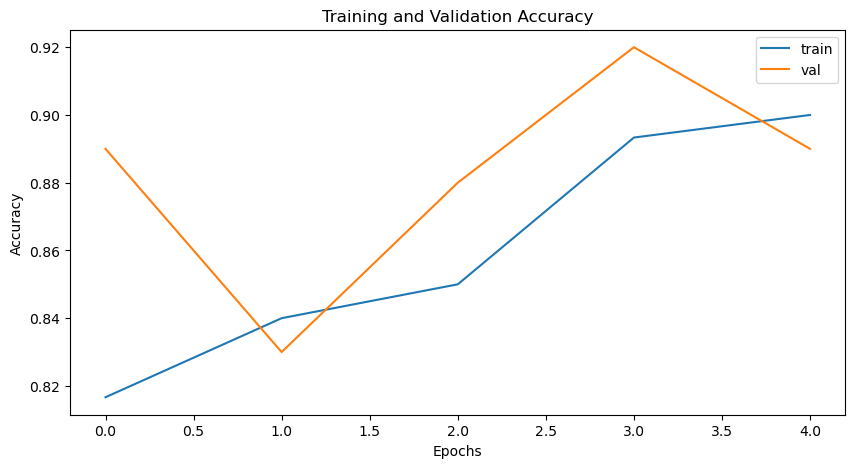

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc, label="train")
plt.plot(val_acc, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
